## ID5030: Assignment 5
### ME20B087 Janmenjaya Panda
### RNN in PyTorch

### 1. Load the required libraries such as Pandas, NumPy, Matplotlib, Pytorch and Sklearn.

In [1]:
# importing the modules
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date
import holidays
from tabulate import tabulate

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Download the dataset from the given link and read it into a Pandas dataframe.

In [3]:
# Read the dataset
dataset = pd.read_csv("rnn_dataset.csv")

dataset.head # show top n (5 by default) rows of the data frame

<bound method NDFrame.head of                    Datetime  PJMW_MW
0       2002-12-31 01:00:00   5077.0
1       2002-12-31 02:00:00   4939.0
2       2002-12-31 03:00:00   4885.0
3       2002-12-31 04:00:00   4857.0
4       2002-12-31 05:00:00   4930.0
...                     ...      ...
143201  2018-01-01 20:00:00   8401.0
143202  2018-01-01 21:00:00   8373.0
143203  2018-01-01 22:00:00   8238.0
143204  2018-01-01 23:00:00   7958.0
143205  2018-01-02 00:00:00   7691.0

[143206 rows x 2 columns]>

In [4]:
# show no of rows* no. of columns
print(dataset.shape)  

(143206, 2)


### 3. Create a new data frame where the features are the previous 100 values, and the label is the current value. This can be done using the Pandas shift() function.

In [5]:
# Function for creating new dataset with lags
def create_dataset(data, lags):
    data_new = dataset.copy()
    for n in range(1, lags + 1):
        data_new[f"lag{n}"] = data_new['PJMW_MW'].shift(n)
    data_new = data_new.iloc[lags:]
    return data_new

# Creat new dataset
dataset = dataset.set_index(['Datetime' ])
dataset.index = pd.to_datetime(dataset.index)
if not dataset.index.is_monotonic:
    dataset = dataset.sort_index()
    
window_size = 100
data_features = create_dataset(dataset, window_size)
data_features

,PJMW_MW,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-05 05:00:00,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,...,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,4306.0,4374.0
2002-04-05 06:00:00,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,...,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,4306.0
2002-04-05 07:00:00,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,...,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0
2002-04-05 08:00:00,6240.0,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,...,5637.0,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0
2002-04-05 09:00:00,6113.0,6240.0,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,...,5571.0,5637.0,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,6693.0,6758.0,6708.0,6627.0,6492.0,6425.0,6299.0,6152.0,6050.0,...,4731.0,5160.0,5612.0,6034.0,6257.0,6454.0,6632.0,6688.0,6566.0,6359.0
2018-08-02 21:00:00,6496.0,6545.0,6693.0,6758.0,6708.0,6627.0,6492.0,6425.0,6299.0,6152.0,...,4593.0,4731.0,5160.0,5612.0,6034.0,6257.0,6454.0,6632.0,6688.0,6566.0
2018-08-02 22:00:00,6325.0,6496.0,6545.0,6693.0,6758.0,6708.0,6627.0,6492.0,6425.0,6299.0,...,4416.0,4593.0,4731.0,5160.0,5612.0,6034.0,6257.0,6454.0,6632.0,6688.0


### 4. Do a train-validation-test split of the data. The recommended split is 70-15-15, i.e., 70% of the data for training, 15% for validation, and 15% for testing.

In [6]:
# Divide the dataset into Training, Validate, Test datasets using a 70:15:15 ratio
def feature_label_split(dataset, target_col):
    y = dataset[[target_col]]
    x = dataset.drop(columns=[target_col])
    return x, y

def train_val_test_split(dataset, target_col, val_ratio, test_ratio):
    # Obtain x, y data
    x, y = feature_label_split(dataset, target_col)
    X, x_test, Y, y_test =train_test_split(x, y, test_size = test_ratio, random_state=10)
    x_train, x_val, y_train, y_val =train_test_split(X, Y, test_size = (val_ratio/(1-test_ratio)), random_state=10)
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(data_features, 'PJMW_MW', 0.15, 0.15)

In [7]:
print(x_train.shape)
print(x_train.shape[0]/data_features.shape[0])

(100174, 100)
0.699998602434559


In [8]:
y_train.shape

(100174, 1)

In [9]:
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [10]:
scaler = get_scaler('minmax')
x_train_arr = scaler.fit_transform(x_train)
x_val_arr = scaler.transform(x_val)
x_test_arr = scaler.transform(x_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

### 5. Train a recurrent neural network (RNN) on the created data frame. We can use Pytorch, a high-level neural network library for Python, to create and train the RNN.

In [11]:
batch_size = 10

train_features = torch.Tensor(x_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(x_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(x_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [12]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [13]:
class Optimization:
    
    def __init__(self, model, loss_fn, optimizer):
        
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= n_epochs) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [14]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel
    }
    return models.get(model.lower())(**model_params)

### 7. Plot the learning curves for the RNN. This can be done using Matplotlib to plot the training and validation loss against the number of epochs.

[1/50] Training loss: 0.0019	 Validation loss: 0.0019
[2/50] Training loss: 0.0009	 Validation loss: 0.0008
[3/50] Training loss: 0.0007	 Validation loss: 0.0003
[4/50] Training loss: 0.0007	 Validation loss: 0.0004
[5/50] Training loss: 0.0006	 Validation loss: 0.0004
[6/50] Training loss: 0.0006	 Validation loss: 0.0004
[7/50] Training loss: 0.0006	 Validation loss: 0.0005
[8/50] Training loss: 0.0006	 Validation loss: 0.0007
[9/50] Training loss: 0.0005	 Validation loss: 0.0004
[10/50] Training loss: 0.0005	 Validation loss: 0.0003
[11/50] Training loss: 0.0005	 Validation loss: 0.0003
[12/50] Training loss: 0.0005	 Validation loss: 0.0006
[13/50] Training loss: 0.0005	 Validation loss: 0.0006
[14/50] Training loss: 0.0005	 Validation loss: 0.0008
[15/50] Training loss: 0.0005	 Validation loss: 0.0003
[16/50] Training loss: 0.0005	 Validation loss: 0.0003
[17/50] Training loss: 0.0005	 Validation loss: 0.0003
[18/50] Training loss: 0.0005	 Validation loss: 0.0002
[19/50] Training lo

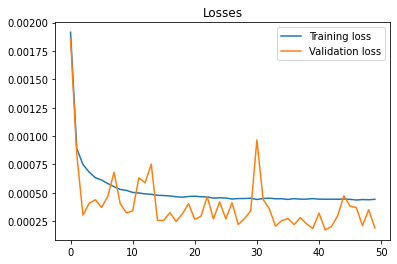

In [15]:
input_dim = len(x_train.columns)
output_dim = 1
hidden_dim = 50
layer_dim = 3
batch_size = 10
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('rnn', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [16]:
def inverse_transform(scaler, dataset, columns):
    for col in columns:
        dataset[col] = scaler.inverse_transform(dataset[col])
    return dataset


def format_predictions(predictions, values, dataset_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    dataset_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=dataset_test.head(len(vals)).index)
    dataset_result = dataset_result.sort_index()
    dataset_result = inverse_transform(scaler, dataset_result, [["value", "prediction"]])
    return dataset_result


dataset_result = format_predictions(predictions, values, x_test, scaler)
dataset_result

,value,prediction
Datetime,,
2002-04-05 06:00:00,5516.0,5460.375488
2002-04-05 13:00:00,5815.0,5827.175293
2002-04-05 22:00:00,5946.0,5837.305176
2002-04-06 20:00:00,5724.0,5615.606934
2002-04-06 21:00:00,5729.0,5692.432129
...,...,...
2018-08-01 00:00:00,5343.0,5349.109375
2018-08-01 03:00:00,4687.0,4599.960938
2018-08-01 15:00:00,6980.0,6933.010254


### 6. Evaluate the performance of the trained RNN by calculating the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (𝑅 2 ) values for the predictions on the test set. These metrics can be calculated using Sklearn’s mean_squared_error(), mean_absolute_error(), and r2_score() functions, respectively.

In [17]:
def calculate_metrics(dataset):
    result_metrics = {'mae' : mean_absolute_error(dataset.value, dataset.prediction),
                      'rmse' : mean_squared_error(dataset.value, dataset.prediction) ** 0.5,
                      'r2' : r2_score(dataset.value, dataset.prediction)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

result_metrics = calculate_metrics(dataset_result)


Mean Absolute Error:        72.64086
Root Mean Squared Error:    103.23843193367962
R^2 Score:                  0.9889029642152505


### 8. Instead of using the previous values as features, use the hour, day, day of the week, week of the year information, as well as the periodicity information, along with checking whether the day is a holiday using the holiday module as features to predict the current value using RNN. This can be done by creating a new dataframe with these features and labels.

In [18]:
dataset_features = (
                dataset
                .assign(hour = dataset.index.hour)
                .assign(day = dataset.index.day)
                .assign(month = dataset.index.month)
                .assign(day_of_week = dataset.index.dayofweek)
                .assign(week_of_year = dataset.index.week)
              )

In [19]:
def onehot_encode(dataset, cols):
    for col in cols:
        dummies = pd.get_dummies(dataset[col], prefix=col)
    
    return pd.concat([dataset, dummies], axis=1).drop(columns=cols)

dataset_features = onehot_encode(dataset_features, ['month','day','day_of_week','week_of_year'])
dataset_features

,PJMW_MW,hour,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 02:00:00,4306.0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 03:00:00,4322.0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 04:00:00,4359.0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-04-01 05:00:00,4436.0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-08-02 21:00:00,6496.0,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-08-02 22:00:00,6325.0,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
def cyclical_features(dataset, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(dataset[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(dataset[col_name]-start_num)/period)    
             }
    return dataset.assign(**kwargs).drop(columns=[col_name])

dataset_features = cyclical_features(dataset_features, 'hour', 24, 0)

dataset_features

,PJMW_MW,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,...,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,sin_hour,cos_hour
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.258819,0.965926
2002-04-01 02:00:00,4306.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.500000,0.866025
2002-04-01 03:00:00,4322.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.707107,0.707107
2002-04-01 04:00:00,4359.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866025,0.500000
2002-04-01 05:00:00,4436.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.965926,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.866025,0.500000
2018-08-02 21:00:00,6496.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.707107,0.707107
2018-08-02 22:00:00,6325.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.500000,0.866025


In [21]:
us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(dataset, holidays):
    return dataset.assign(is_holiday = dataset.index.to_series().apply(is_holiday))


dataset_features = add_holiday_col(dataset_features, us_holidays)
dataset_features

,PJMW_MW,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,...,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,sin_hour,cos_hour,is_holiday
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.258819,0.965926,0
2002-04-01 02:00:00,4306.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.500000,0.866025,0
2002-04-01 03:00:00,4322.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.707107,0.707107,0
2002-04-01 04:00:00,4359.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.866025,0.500000,0
2002-04-01 05:00:00,4436.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.965926,0.258819,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.866025,0.500000,0
2018-08-02 21:00:00,6496.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.707107,0.707107,0
2018-08-02 22:00:00,6325.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.500000,0.866025,0


### 9. Train an RNN on the new dataframe using the same architecture as before

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(dataset_features, 'PJMW_MW', 0.15, 0.15)

In [24]:
scaler = get_scaler('minmax')
x_train_arr = scaler.fit_transform(x_train)
x_val_arr = scaler.transform(x_val)
x_test_arr = scaler.transform(x_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [26]:
batch_size = 10

train_features = torch.Tensor(x_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(x_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(x_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

### 11. Plot the learning curves for the new RNN.

[1/50] Training loss: 0.0059	 Validation loss: 0.0050
[2/50] Training loss: 0.0051	 Validation loss: 0.0047
[3/50] Training loss: 0.0049	 Validation loss: 0.0046
[4/50] Training loss: 0.0048	 Validation loss: 0.0046
[5/50] Training loss: 0.0047	 Validation loss: 0.0046
[6/50] Training loss: 0.0047	 Validation loss: 0.0046
[7/50] Training loss: 0.0047	 Validation loss: 0.0046
[8/50] Training loss: 0.0047	 Validation loss: 0.0046
[9/50] Training loss: 0.0047	 Validation loss: 0.0046
[10/50] Training loss: 0.0047	 Validation loss: 0.0046
[11/50] Training loss: 0.0047	 Validation loss: 0.0046
[12/50] Training loss: 0.0047	 Validation loss: 0.0046
[13/50] Training loss: 0.0047	 Validation loss: 0.0046
[14/50] Training loss: 0.0047	 Validation loss: 0.0046
[15/50] Training loss: 0.0047	 Validation loss: 0.0046
[16/50] Training loss: 0.0046	 Validation loss: 0.0046
[17/50] Training loss: 0.0047	 Validation loss: 0.0045
[18/50] Training loss: 0.0046	 Validation loss: 0.0045
[19/50] Training lo

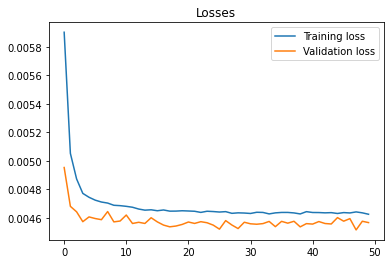

In [27]:
input_dim = len(x_train.columns)
output_dim = 1
hidden_dim = 50
layer_dim = 3
batch_size = 10
dropout = 0.2
n_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('rnn', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [28]:
dataset_result = format_predictions(predictions, values, x_test, scaler)
dataset_result

,value,prediction
Datetime,,
2002-04-01 02:00:00,4306.000000,4580.787109
2002-04-01 09:00:00,5616.000000,5584.393066
2002-04-01 18:00:00,5323.000000,5381.265137
2002-04-02 16:00:00,5226.000000,5239.051758
2002-04-02 17:00:00,5228.000000,5269.306641
...,...,...
2018-08-01 03:00:00,4686.999512,4658.586426
2018-08-01 04:00:00,4587.999512,4599.458984
2018-08-02 15:00:00,6492.000488,6983.519531


### 10. Evaluate the performance of the trained RNN by calculating the MSE, RMSE, and 𝑅 2 values for the predictions on the test set.

In [30]:
result_metrics = calculate_metrics(dataset_result)

Mean Absolute Error:        470.7419
Root Mean Squared Error:    607.0294473911459
R^2 Score:                  0.6094153280848584


### 12. Compare the performance of the two RNNs and determine which feature engineering method is better for the given dataset.

In [34]:
print("Method 1 (Used 100 Previous Values):")
print("Mean Absolute Error: 72.64086\nRoot Mean Squared Error: 103.23843193367962\nR^2 Score: 0.9889029642152505\n")

print("Method 2 (Used the hour, day, day of the week, week of year info):")
print("Mean Absolute Error: 470.7419\nRoot Mean Squared Error: 607.0294473911459\nR^2 Score: 0.6094153280848584\n")

Method 1 (Used 100 Previous Values):
Mean Absolute Error: 72.64086
Root Mean Squared Error: 103.23843193367962
R^2 Score: 0.9889029642152505

Method 2 (Used the hour, day, day of the week, week of year info):
Mean Absolute Error: 470.7419
Root Mean Squared Error: 607.0294473911459
R^2 Score: 0.6094153280848584



### Reference Used:
[https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b](https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b)